In [1]:
%load_ext autoreload
%autoreload 2
import mkl
mkl.set_num_threads(1)


48

# Multi-bin analysis
(actual PLEnuM style)

In [2]:
import pickle
from collections import namedtuple
from itertools import product
from copy import copy
from os.path import join

import numpy as np
import pandas as pd
import seaborn as sns

plt = sns.mpl.pyplot
from aeff_calculations import calc_aeff_factor
from fluxes import (
    astro_flux,
    atmo_background,
    cut_off,
    power_law,
)
import mephisto
from matplotlib.colors import LogNorm
from scipy.optimize import fmin_l_bfgs_b
from scipy.interpolate import InterpolatedUnivariateSpline

from scipy.stats import chi2, norm
from settings import LOCALPATH, BASEPATH, sigma1, sigma3, sigma5
import settings as st
from tools import array_source_interp, get_scaler, get_mids, scaling_estimation
from likelihood import poisson_llh, ps_llh_single
from tqdm import tqdm
from scipy.stats import rayleigh
from mephisto import Mephistogram, plot_multiple_mephistograms
from settings import PHI_NGC, GAMMA_NGC, E0_NGC, LIVETIME

# energy resolution files
e_res_files = {"baseline": join(LOCALPATH, "energy_smearing_GP_up.pckl")}

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


# Load detector performance files

In [3]:
# energy resolution files
e_res_files = {
    "baseline": join(LOCALPATH, "energy_smearing_GP_up.pckl"),
    "reproduction": join(LOCALPATH, "artificial_smoothed_energy_smearing_GP_up.pckl"),
    "1:1": join(LOCALPATH, "idealized_artificial_energy_smearing_GP_up.pckl"),
    "improved-20": join(
        LOCALPATH, "improved_0.2_artificial_energy_smearing_GP_up.pckl"
    ),
    "improved-50": join(
        LOCALPATH, "improved_0.5_artificial_energy_smearing_GP_up.pckl"
    ),
}

In [4]:
# Effective area

#We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.
with open(join(LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)
# print(aeff_2d.keys())
# print(aeff_2d["IceCube"])
# Atmospheric background

with open(join(LOCALPATH, "atmospheric_background_daemonflux_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)

# check if histos are matching
print(bckg_histo["IceCube"].match(aeff_2d["IceCube"], verbose=True))
# Energy resolution function
# baseline resolution
with open(e_res_files["baseline"], "rb") as f:
    baseline_eres = pickle.load(f)
baseline_eres.normalize(axis=1)  # normalize per logE_true

# resolution improved by 50%
with open(e_res_files["improved-50"], "rb") as f:
    improved_eres = pickle.load(f)
improved_eres.normalize(axis=1)  # normalize per logE_true

# checking if matrix multiplication is possible
print(aeff_2d["IceCube"].match_matmul(baseline_eres, verbose=True))
# ... it's not commutative, though
print(baseline_eres.match_matmul(aeff_2d["IceCube"], verbose=True, raise_err=False))
energy_reso = {"baseline": baseline_eres, "improved": improved_eres} # easy access
# Flux definition
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
PLcut_flux = namedtuple("PLcut_flux", "norm gamma e_cut E0 shape")
LogP_flux = namedtuple("LogP_flux", "norm alpha beta E0 shape")

flux_collection = {
    "powerlaw": PL_flux,
}
E2_flux = PL_flux(1E-15, 2, 1E3, "powerlaw")

Elementary arithmetic possible.
True
Matrix multiplication possible.
True
Matrix multiplication not possible. Shapes are (140, 139) and (100, 140);
False


# example PSF definition

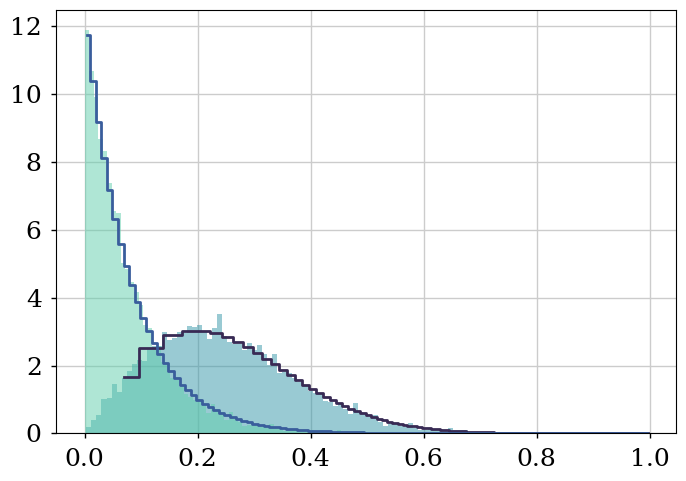

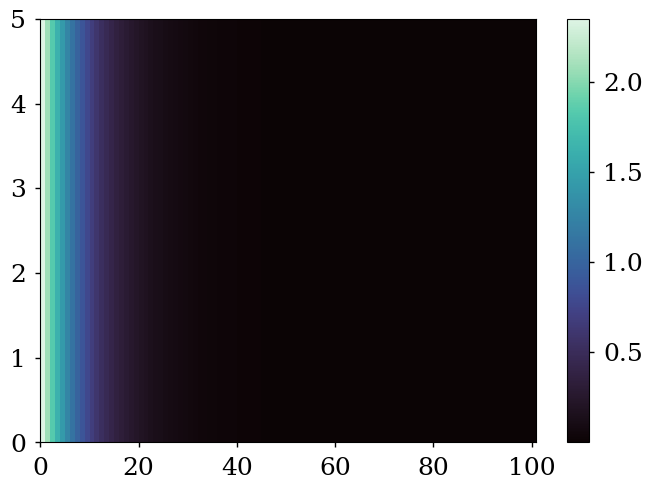

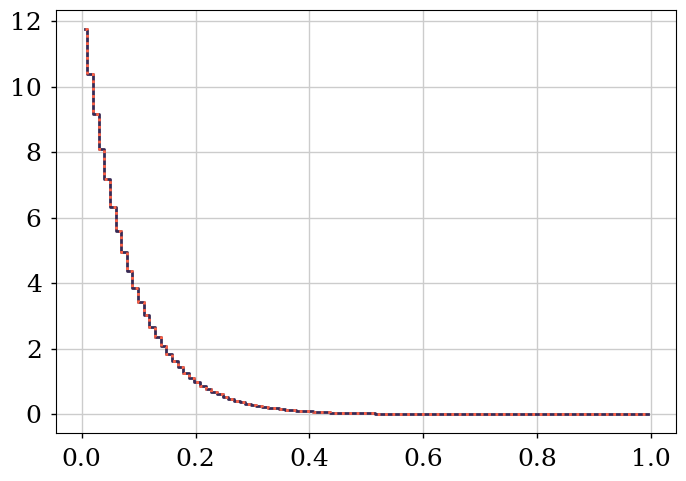

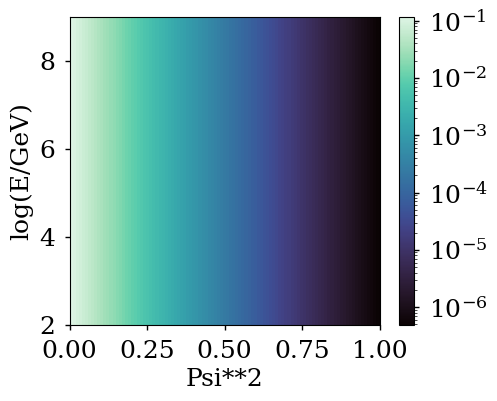

In [5]:
delta_psi_max = 1
psi2_bins = np.linspace(0.0, delta_psi_max**2, num=102)
yy = psi2_mids = get_mids(psi2_bins)
xx = np.sqrt(yy)
scale = 0.2
rvals = rayleigh.rvs(scale=scale, size=int(1e4))
plt.plot(xx, rayleigh.pdf(xx, scale=scale), ds="steps-mid")
plt.plot(yy, rayleigh.pdf(xx, scale=scale) / xx / 2, ds="steps-mid")
plt.hist(rvals, density=True, alpha=0.5, bins=100)
_ = plt.hist(rvals**2, density=True, alpha=0.5, bins=100)
# plt.yscale("log")
y = rayleigh.pdf(xx, scale=scale) / xx / 2
twoD = np.tile(y, 5).reshape(5, len(y)) / 5
plt.figure()
plt.pcolormesh(twoD)
plt.colorbar()

plt.figure()
plt.plot(yy, twoD.sum(axis=0), ds="steps-mid")
plt.plot(yy, y, ds="steps-mid", ls=":", color="tomato")

len_e = len(st.logE_mids)
e_psi2_grid = Mephistogram(
    np.tile(y, len_e).reshape(len_e, len(y)).T / len_e,
    (psi2_bins, st.logE_bins),
    ("Psi**2", "log(E/GeV)"),
    make_hist=False,
)
e_psi2_grid.normalize()
# uniform, normalized background grid
bckg_psi2_grid = mephisto.like(e_psi2_grid, fill_value=1)
bckg_psi2_grid.normalize()
e_psi2_grid.plot(norm=LogNorm())

# config

events: 17.93969609352128


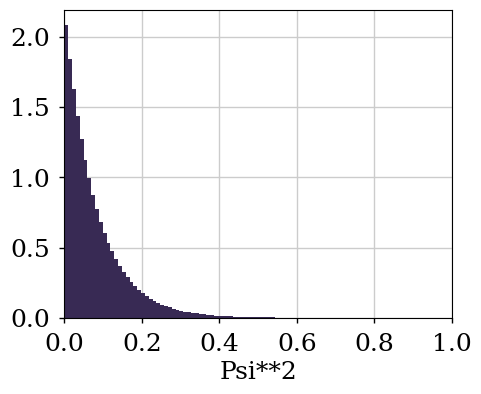

In [6]:
src_config = dict(
    sindec_mids=st.sindec_mids,
    livetime=LIVETIME,
    ewidth=st.ewidth,
    dec=0
)
# generic bg config
bg_config = copy(src_config)


cur_bg_conf = bg_config.copy()
cur_src_conf = src_config.copy()
cur_bg_conf["dpsi_max"] = delta_psi_max
cur_bg_conf["grid_2d"] =bckg_psi2_grid
cur_src_conf["dpsi_max"] = 0
cur_src_conf["grid_2d"] = e_psi2_grid

ident = "IceCube"
# check that the bins match
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **cur_src_conf)

k_s = astro_flux(
    aeff_factor_signal,
    10**aeff_2d[ident].bin_mids[1],
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=E2_flux,
)
print("events:", np.sum(k_s)) 
k_s.sum(axis=1, return_mephisto=True).plot() # collaps down to 1D for simplicity

# LLH setup

In [7]:
def ps_llh_single_1D(
    x,
    aeff_factor_s,
    aeff_factor_b,
    bckg_flux,
    k_i,
    energy_resolution,
    e_0,
    phi_0,
    shape,
    verbose=False,
):
    """
    Calculate the log-likelihood using Poisson statistics for a single dataset assuming consistent properties.

    Parameters:
        x (list): Fit parameters.
            x[0]: Background normalization scaling.
            x[1]: Signal normalization scaling.
            x[2:]: Other signal parameters. See 'astro_flux' for further shapes and parameters.
        aeff_factor_s (float): Effective area factor for the signal.
        aeff_factor_b (float): Effective area factor for the background.
        bckg_flux (list): Background flux values.
        k_i (array-like): Observation/Asimov data.
        energy_resolution (float): Energy resolution.
        e_0 (float): Normalization energy. Default value is E0_NGC.
        phi_0 (float): Normalization flux. Default value is PHI_NGC.
        shape (str): Flux shape.
        verbose (bool, optional): Whether to print additional information. Default is False.

    Returns:
        float: -2 * Log-likelihood value calculated using Poisson statistics. See 'poisson_llh'.

    Note:
        This function assumes that there is only one dataset with consistent properties.
    """
    # Calculate the background contribution
    mu_b = (
        atmo_background(
            aeff_factor=aeff_factor_b,
            bckg_vals=bckg_flux,
            energy_resolution=energy_resolution,
        )
        * x[0]
    ).sum(axis=1, return_mephisto=True)
    # Calculate the signal contribution
    mu_s = astro_flux(
        aeff_factor_s,
        10**aeff_factor_s.bin_mids[1],
        energy_resolution,
        x[1],
        flux_collection[shape](
            phi_0, *x[2:], e_0, shape
        ),  # here we generate a flux tuple with the current parameters
    ).sum(axis=1, return_mephisto=True)
    if verbose:
        # Print additional information if verbose mode is enabled
        print(x[0], x[1], *x[2:])
        print(flux_collection[shape](phi_0, *x[2:], e_0, shape))
        print(np.sum(mu_b), np.sum(mu_s))

    # Calculate the total expected events for the Poisson LLH
    mu_i = mu_s + mu_b

    # Calculate -2 * log-likelihood using Poisson statistics
    return poisson_llh(mu_i, k_i)

# 2D, real PSF

In [8]:
# angular resolution
with open(join(LOCALPATH, f"Psi2-{st.delta_psi_max}_res_mephistograms.pckl"), "rb") as f:
    all_psi = pickle.load(f)
e_psi2_baseline = all_psi["dec-0.0"]
e_psi2_baseline.normalize()

# uniform, normalized background grid
bckg_psi2_baseline = mephisto.like(e_psi2_baseline, fill_value=1)
bckg_psi2_baseline.normalize()

In [9]:
all_psi["dec-0.0"].normalize()
all_psi["dec-50.0"].normalize()

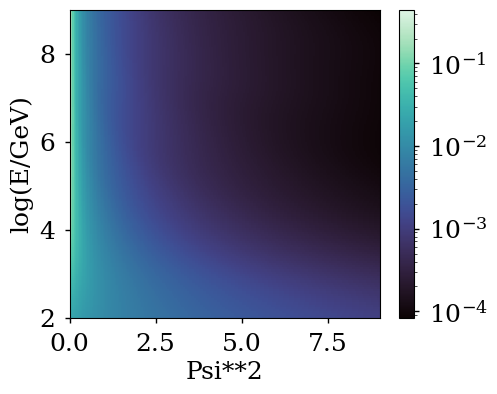

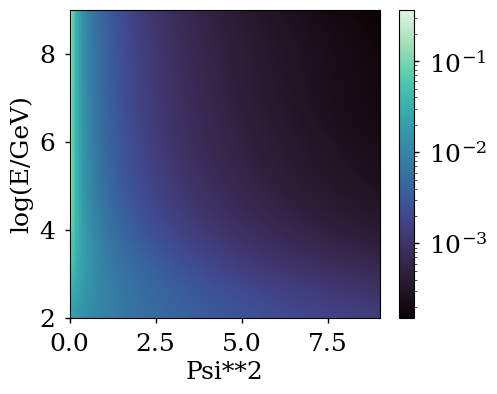

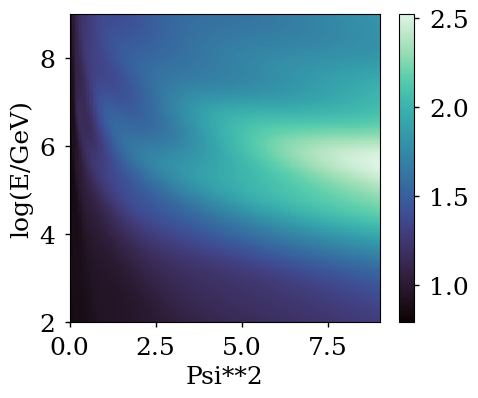

In [10]:
all_psi["dec-0.0"].plot(norm=LogNorm())
all_psi["dec-50.0"].plot(norm=LogNorm())
(all_psi["dec-50.0"]/all_psi["dec-0.0"]).plot()

## significance scaling

### gamma=-2

In [11]:
scalings = np.logspace(-2, 2, num=30)
ident = "IceCube"
results = []
dimensions = ["1D", "2D"]

for dim, psf_scaler in product(dimensions, scalings):
    tmp_psi = copy(e_psi2_baseline)  # simply change axis?
    delta_psi_max = st.delta_psi_max * psf_scaler
    tmp_psi.set_bins((e_psi2_baseline.bins[0] * psf_scaler, e_psi2_baseline.bins[1]))
    # uniform, normalized background grid
    tmp_bckg_psi2 = mephisto.like(tmp_psi, fill_value=1)
    tmp_bckg_psi2.normalize()

    # new config
    cur_bg_conf = bg_config.copy()
    cur_src_conf = src_config.copy()
    cur_bg_conf["dpsi_max"] = delta_psi_max
    cur_bg_conf["grid_2d"] = tmp_bckg_psi2
    cur_src_conf["dpsi_max"] = 0
    cur_src_conf["grid_2d"] = tmp_psi

    aeff_factor_b = calc_aeff_factor(aeff_2d[ident], **cur_bg_conf)
    aeff_factor_s = calc_aeff_factor(aeff_2d[ident], **cur_src_conf)

    # Calculate background flux
    bckg_flux = array_source_interp(
        cur_bg_conf["dec"], bckg_histo[ident], bckg_histo["IceCube"].bin_mids[0], axis=1
    )

    # Calculate asimov data for atmospheric background
    k_b = atmo_background(
        aeff_factor=aeff_factor_b,
        bckg_vals=bckg_flux,
        energy_resolution=energy_reso["baseline"],
    )
    # Calculate asimov data for astrophysical signal with power law spectrum
    k_s = astro_flux(
        aeff_factor=aeff_factor_s,
        emids=10 ** aeff_factor_s.bin_mids[1],
        energy_resolution=energy_reso["baseline"],
        phi_scaling=1,
        flux_shape=E2_flux,  # powerlaw
    )

    if dim == "1D":
        k_b = k_b.sum(axis=1, return_mephisto=True)
        k_s = k_s.sum(axis=1, return_mephisto=True)

    dct = dict(
        shape="powerlaw",
        aeff_factor_s=aeff_factor_s,
        aeff_factor_b=aeff_factor_b,
        k_i=k_s + k_b,
        bckg_flux=bckg_flux,
        energy_resolution=energy_reso["baseline"],
        e_0=E2_flux.E0,
        phi_0=E2_flux.norm,
    )

    if dim == "1D":
        # fix signal contribution to 0 for background fit
        local_llh = lambda x: ps_llh_single_1D((x[0], 0, 3), **dct)
        global_llh = lambda x: ps_llh_single_1D(x, **dct)
    else:
        # fix signal contribution to 0 for background fit
        local_llh = lambda x: ps_llh_single((x[0], 0, 3), **dct)
        global_llh = lambda x: ps_llh_single(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )

    # this fit is not really needed, but good for crosschecking the code
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, E2_flux.gamma),
        approx_grad=True,
    )

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = norm.isf(pval)
    results.append(
        {
            "significance": significance,
            "pval": pval,
            "ident": f"IC + {ident}" if ident == "P-ONE" else ident,
            "psf_scale": psf_scaler,
            "dimension": dim,
            "n_s": np.sum(k_s),
            "n_b": np.sum(k_b),
        }
    )

    if False:
        k_s.plot()
        k_b.plot()
results = pd.DataFrame(results)
# print(results)

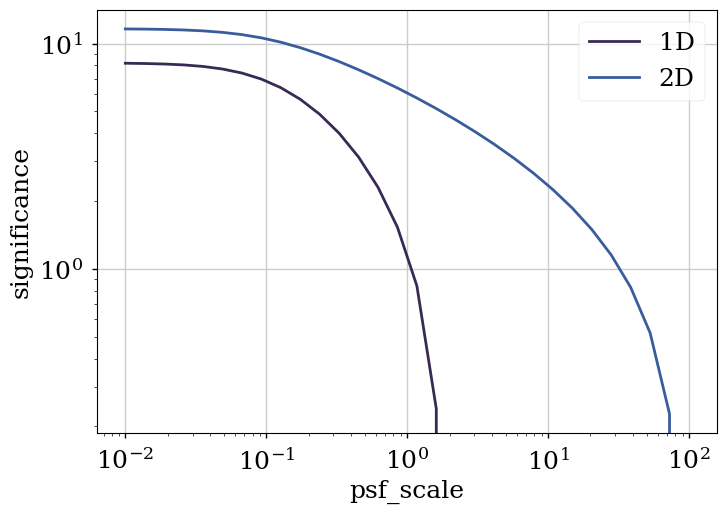

In [12]:
ax = sns.lineplot(data=results, x="psf_scale", y="significance", hue="dimension")
#ax.plot(scalings, 1/np.sqrt(scalings), ls="--", color="tomato", lw=1, label= "square-root-y")
ax.loglog()
ax.legend()

## DP gamma = -2


In [13]:
ident = "IceCube"
results = []
len_e = len(st.logE_mids)
E2_flux = PL_flux(4e-15, 2, 1e3, "powerlaw")
scalings = np.logspace(-2, 1, 10)
thresholds = [sigma5]

dimensions = ["1D", "2D"]

for dim, psf_scaler in product(dimensions, scalings):
    tmp_psi = copy(e_psi2_baseline)  # simply change axis?
    delta_psi_max = st.delta_psi_max * psf_scaler
    tmp_psi.set_bins((e_psi2_baseline.bins[0] * psf_scaler, e_psi2_baseline.bins[1]))
    # uniform, normalized background grid
    tmp_bckg_psi2 = mephisto.like(tmp_psi, fill_value=1)
    tmp_bckg_psi2.normalize()

    # new config
    cur_bg_conf = bg_config.copy()
    cur_src_conf = src_config.copy()
    cur_bg_conf["dpsi_max"] = delta_psi_max
    cur_bg_conf["grid_2d"] = tmp_bckg_psi2
    cur_src_conf["dpsi_max"] = 0
    cur_src_conf["grid_2d"] = tmp_psi

    aeff_factor_b = calc_aeff_factor(aeff_2d[ident], **cur_bg_conf)
    aeff_factor_s = calc_aeff_factor(aeff_2d[ident], **cur_src_conf)

    # Calculate background flux
    bckg_flux = array_source_interp(
        cur_bg_conf["dec"], bckg_histo[ident], bckg_histo["IceCube"].bin_mids[0], axis=1
    )

    # Calculate asimov data for atmospheric background
    k_b = atmo_background(
        aeff_factor=aeff_factor_b,
        bckg_vals=bckg_flux,
        energy_resolution=energy_reso["baseline"],
    )

    # Calculate asimov data for astrophysical signal with power law spectrum
    k_s = astro_flux(
        aeff_factor=aeff_factor_s,
        emids=10 ** aeff_factor_s.bin_mids[1],
        energy_resolution=energy_reso["baseline"],
        phi_scaling=1,
        flux_shape=E2_flux,  # powerlaw
    )

    if dim == "1D":
        k_b = k_b.sum(axis=1, return_mephisto=True)
        k_s = k_s.sum(axis=1, return_mephisto=True)

    # calculate an estimate for the flux scaling
    scaler = 5 / (np.sum(k_s) / np.sqrt(np.sum(k_b)))
    current_thresholds = copy(thresholds)
    count = 0

    # calculate the significance with various flux scalings to obtain
    # the 5-sigma discovery threshold by interpolation
    while len(current_thresholds) > 0:
        current_k_s = k_s * scaler
        current_k = current_k_s + k_b

        dct = dict(
            shape="powerlaw",
            aeff_factor_s=aeff_factor_s,
            aeff_factor_b=aeff_factor_b,
            k_i=current_k,
            bckg_flux=bckg_flux,
            energy_resolution=energy_reso["baseline"],
            e_0=E2_flux.E0,
            phi_0=E2_flux.norm,
        )

        if dim == "1D":
            # fix signal contribution to 0 for background fit
            local_llh = lambda x: ps_llh_single_1D((x[0], 0, 3), **dct)
            global_llh = lambda x: ps_llh_single_1D(x, **dct)
        else:
            # fix signal contribution to 0 for background fit
            local_llh = lambda x: ps_llh_single((x[0], 0, 3), **dct)
            global_llh = lambda x: ps_llh_single(x, **dct)

        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1,),
            approx_grad=True,
        )

        # this fit is not really needed, but good for crosschecking the code
        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1, 1, E2_flux.gamma),
            approx_grad=True,
        )

        pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
        logP = -np.log10(pval)

        significance = norm.isf(pval)
        tmp_dct = {
            "ident": ident,
            "psf_scale": psf_scaler,
            "dimension": dim,
            "scaler": scaler,
            "cur_thresh": current_thresholds[0],
            "SosB": np.sum(current_k_s) / np.sqrt(np.sum(k_b)),
            "SoB": np.sum(current_k_s) / np.sum(k_b),
            "n_b": np.sum(k_b),
            "n_sig": np.sum(current_k_s),
            "log10(p)": logP,
            "pval": pval,
        }
        results.append(tmp_dct)
        tmp_df = pd.DataFrame(results)
        mask = (
            (tmp_df.psf_scale == psf_scaler)
            & (tmp_df.cur_thresh == current_thresholds[0])
            & (tmp_df.dimension == dim)
        )
        scaler = scaling_estimation(
            tmp_df.loc[mask], current_thresholds, scaler, stop_here=0.2
        )

        if scaler == -1:
            break
results = pd.DataFrame(results)


Optimization failed! Diff is: 11.620566784983644 thresh is: 1.433257859617676e-07


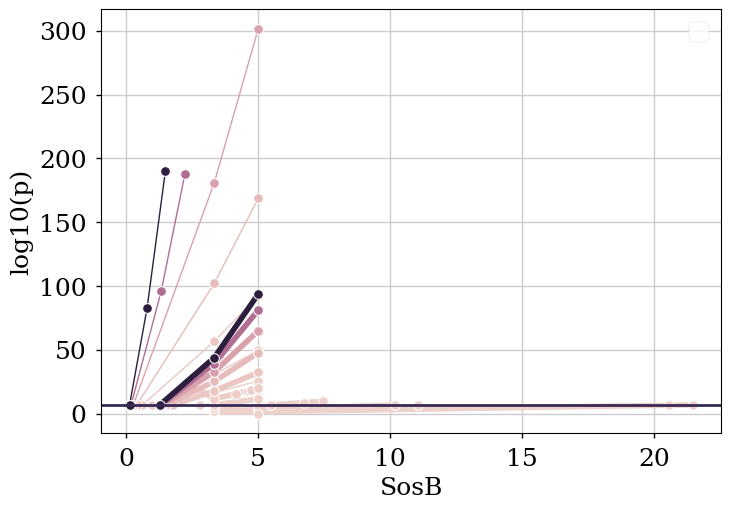

In [14]:
ax = sns.lineplot(
    data=results,  # .loc[df.psf_scale == "base"],
    y="log10(p)",
    x="SosB",
    marker="o",
    hue="psf_scale",
    size="dimension",
)
ax.legend([])
for t in thresholds:
    plt.axhline(-np.log10(t))
# plt.ylim(6, 7)
# plt.xlim(4.5, 6)


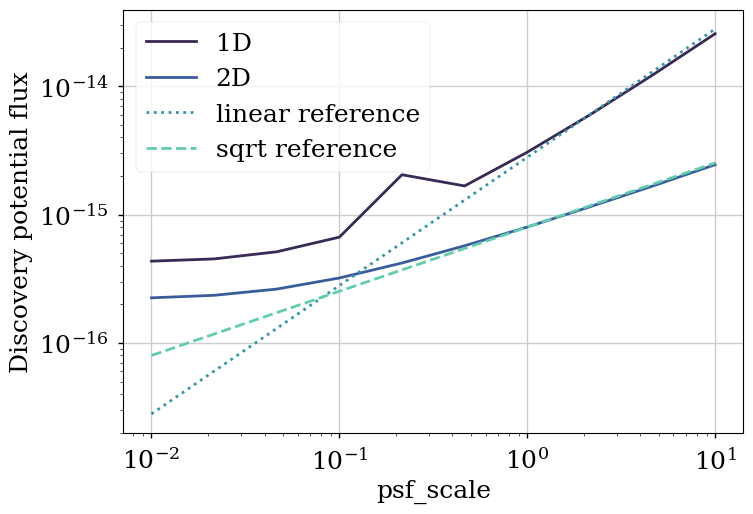

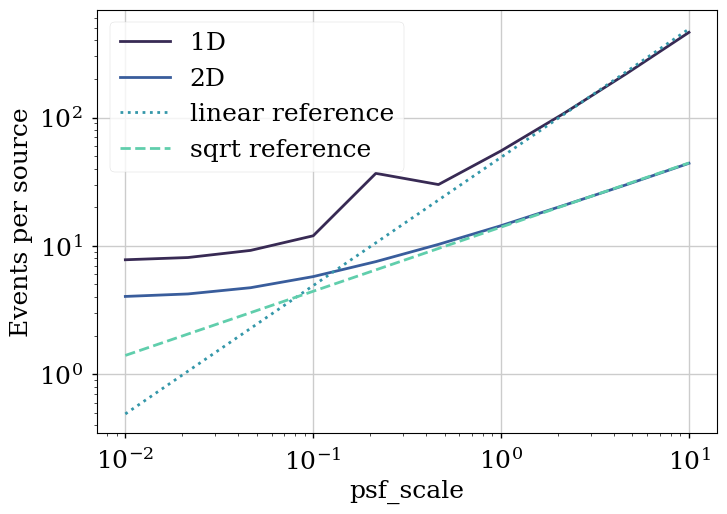

In [15]:
flux = pd.DataFrame(
    results.groupby(["psf_scale", "dimension"]).apply(
        lambda x: get_scaler(x, sigma5)
    )
    * E2_flux.norm,
    columns=["disc5"],
).reset_index()

n_ev = pd.DataFrame(
    results.groupby(["psf_scale", "dimension"]).apply(
        lambda x: get_scaler(x, sigma5, key_y="n_sig")
    ),
    columns=["disc5"],
).reset_index()

# mask = flux.psf_scale>0.3
# fit = np.polyfit(np.log10(flux.psf_scale[mask]), np.log10(flux.disc5[mask]), deg=1)
plt.figure()
ax = sns.lineplot(data=flux, x="psf_scale", y="disc5", hue="dimension")
ax.loglog()
ax.plot(
    flux.psf_scale, flux.psf_scale * 0.8e-14 * 0.35, label="linear reference", ls=":"
)
ax.plot(
    flux.psf_scale,
    np.sqrt(flux.psf_scale) * 0.8e-14 * 0.1,
    label="sqrt reference",
    ls="--",
)
# ax.plot(flux.psf_scale, 10**np.poly1d(fit)(np.log10(flux.psf_scale)), label="fit reference", ls="--")
ax.set_ylabel("Discovery potential flux")
ax.legend()


# mask = flux.psf_scale>0.3
# fit = np.polyfit(np.log10(n_ev.psf_scale[mask]), np.log10(n_ev.disc5[mask]), deg=1)
plt.figure()
ax = sns.lineplot(data=n_ev, x="psf_scale", y="disc5", hue="dimension")
ax.loglog()
ax.plot(n_ev.psf_scale, n_ev.psf_scale * 1.4e2 * 0.35, label="linear reference", ls=":")
ax.plot(
    n_ev.psf_scale,
    np.sqrt(n_ev.psf_scale) * 1.4e2 * 0.1,
    label="sqrt reference",
    ls="--",
)
# ax.plot(n_ev.psf_scale, 10**np.poly1d(fit)(np.log10(n_ev.psf_scale)), label="fit reference", ls="--")
ax.set_ylabel("Events per source")
ax.legend()

## gamma = -3.2

In [16]:
ident = "IceCube"
results = []
len_e = len(st.logE_mids)
E32_flux = PL_flux(1e-13, 3.2, 1e3, "powerlaw")
scalings = np.logspace(-2, 1, 10)
thresholds = [sigma5]

dimensions = ["1D", "2D"]

for dim, psf_scaler in product(dimensions, scalings):
    tmp_psi = copy(e_psi2_baseline)  # simply change axis?
    delta_psi_max = st.delta_psi_max * psf_scaler
    tmp_psi.set_bins((e_psi2_baseline.bins[0] * psf_scaler, e_psi2_baseline.bins[1]))
    # uniform, normalized background grid
    tmp_bckg_psi2 = mephisto.like(tmp_psi, fill_value=1)
    tmp_bckg_psi2.normalize()

    # new config
    cur_bg_conf = bg_config.copy()
    cur_src_conf = src_config.copy()
    cur_bg_conf["dpsi_max"] = delta_psi_max
    cur_bg_conf["grid_2d"] = tmp_bckg_psi2
    cur_src_conf["dpsi_max"] = 0
    cur_src_conf["grid_2d"] = tmp_psi

    aeff_factor_b = calc_aeff_factor(aeff_2d[ident], **cur_bg_conf)
    aeff_factor_s = calc_aeff_factor(aeff_2d[ident], **cur_src_conf)

    # Calculate background flux
    bckg_flux = array_source_interp(
        cur_bg_conf["dec"], bckg_histo[ident], bckg_histo["IceCube"].bin_mids[0], axis=1
    )

    # Calculate asimov data for atmospheric background
    k_b = atmo_background(
        aeff_factor=aeff_factor_b,
        bckg_vals=bckg_flux,
        energy_resolution=energy_reso["baseline"],
    )

    # Calculate asimov data for astrophysical signal with power law spectrum
    k_s = astro_flux(
        aeff_factor=aeff_factor_s,
        emids=10 ** aeff_factor_s.bin_mids[1],
        energy_resolution=energy_reso["baseline"],
        phi_scaling=1,
        flux_shape=E32_flux,  # powerlaw
    )

    if dim == "1D":
        k_b = k_b.sum(axis=1, return_mephisto=True)
        k_s = k_s.sum(axis=1, return_mephisto=True)

    # calculate an estimate for the flux scaling
    scaler = 5 / (np.sum(k_s) / np.sqrt(np.sum(k_b)))
    current_thresholds = copy(thresholds)
    count = 0

    # calculate the significance with various flux scalings to obtain
    # the 5-sigma discovery threshold by interpolation
    while len(current_thresholds) > 0:
        current_k_s = k_s * scaler
        current_k = current_k_s + k_b

        dct = dict(
            shape="powerlaw",
            aeff_factor_s=aeff_factor_s,
            aeff_factor_b=aeff_factor_b,
            k_i=current_k,
            bckg_flux=bckg_flux,
            energy_resolution=energy_reso["baseline"],
            e_0=E32_flux.E0,
            phi_0=E32_flux.norm,
        )

        if dim == "1D":
            # fix signal contribution to 0 for background fit
            local_llh = lambda x: ps_llh_single_1D((x[0], 0, 3), **dct)
            global_llh = lambda x: ps_llh_single_1D(x, **dct)
        else:
            # fix signal contribution to 0 for background fit
            local_llh = lambda x: ps_llh_single((x[0], 0, 3), **dct)
            global_llh = lambda x: ps_llh_single(x, **dct)

        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1,),
            approx_grad=True,
        )

        # this fit is not really needed, but good for crosschecking the code
        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1, 1, E2_flux.gamma),
            approx_grad=True,
        )

        pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
        logP = -np.log10(pval)

        significance = norm.isf(pval)
        tmp_dct = {
            "ident": ident,
            "psf_scale": psf_scaler,
            "dimension": dim,
            "scaler": scaler,
            "cur_thresh": current_thresholds[0],
            "SosB": np.sum(current_k_s) / np.sqrt(np.sum(k_b)),
            "n_b": np.sum(k_b),
            "n_sig": np.sum(current_k_s),
            "log10(p)": logP,
            "pval": pval,
        }
        results.append(tmp_dct)
        tmp_df = pd.DataFrame(results)
        mask = (
            (tmp_df.psf_scale == psf_scaler)
            & (tmp_df.cur_thresh == current_thresholds[0])
            & (tmp_df.dimension == dim)
        )
        scaler = scaling_estimation(
            tmp_df.loc[mask], current_thresholds, scaler, stop_here=0.2
        )

        if scaler == -1:
            break
results = pd.DataFrame(results)
results.to_pickle(join(LOCALPATH, "ngc_psf-scaling_disc_pot.pickle"))

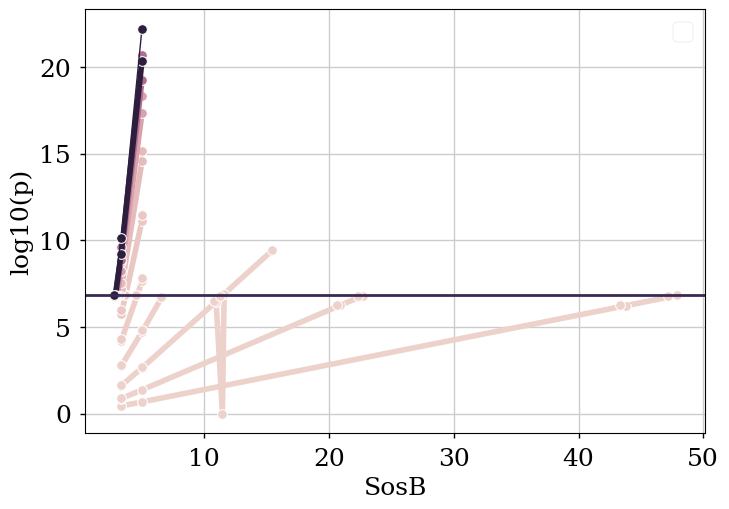

In [17]:

ax = sns.lineplot(
    data=results,  # .loc[df.psf_scale == "base"],
    y="log10(p)",
    x="SosB",
    marker="o",
    hue="psf_scale",
    size="dimension",
)
ax.legend([])
for t in thresholds:
    plt.axhline(-np.log10(t))
# plt.ylim(6, 7)
# plt.xlim(4.5, 6)



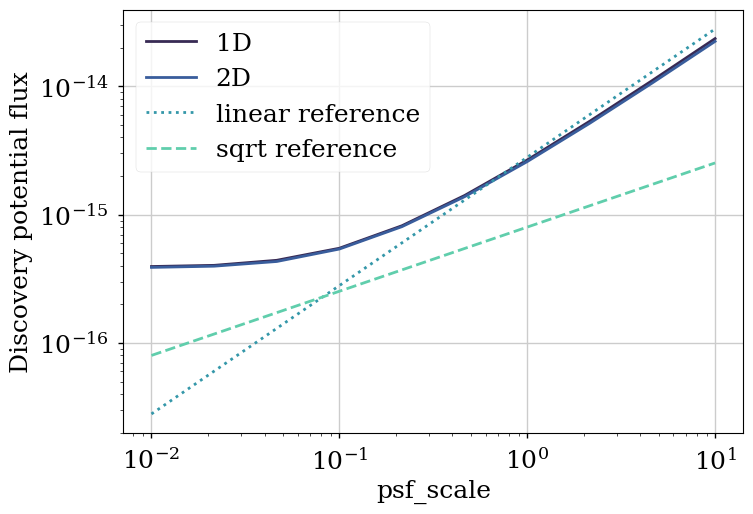

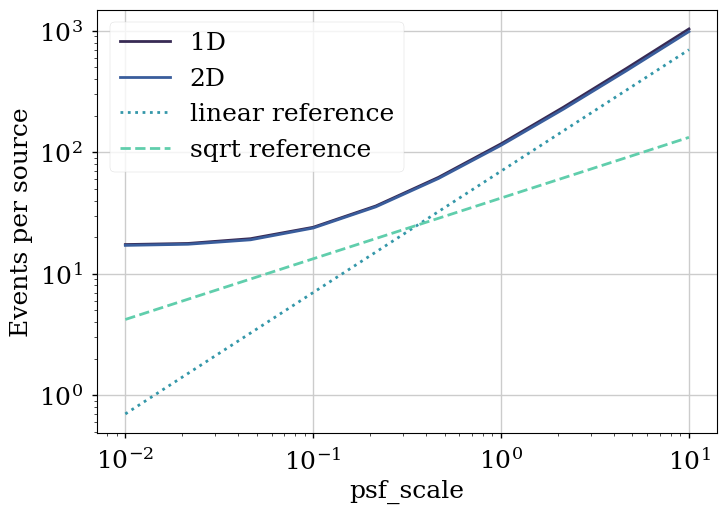

In [18]:

results = pd.read_pickle(join(LOCALPATH, "ngc_psf-scaling_disc_pot.pickle"))
flux = pd.DataFrame(
    results.groupby(["psf_scale", "dimension"]).apply(
        lambda x: get_scaler(x, sigma5)
    )
    * E2_flux.norm,
    columns=["disc5"],
).reset_index()

n_ev = pd.DataFrame(
    results.groupby(["psf_scale", "dimension"]).apply(
        lambda x: get_scaler(x, sigma5, key_y="n_sig")
    ),
    columns=["disc5"],
).reset_index()


# mask = flux.psf_scale>0.3
# fit = np.polyfit(np.log10(flux.psf_scale[mask]), np.log10(flux.disc5[mask]), deg=1)
plt.figure()
ax = sns.lineplot(data=flux, x="psf_scale", y="disc5", hue="dimension")
ax.loglog()
ax.plot(
    flux.psf_scale, flux.psf_scale * 0.8e-14 * 0.35, label="linear reference", ls=":"
)
ax.plot(
    flux.psf_scale,
    np.sqrt(flux.psf_scale) * 0.8e-14 * 0.1,
    label="sqrt reference",
    ls="--",
)
# ax.plot(flux.psf_scale, 10**np.poly1d(fit)(np.log10(flux.psf_scale)), label="fit reference", ls="--")
ax.set_ylabel("Discovery potential flux")
ax.legend()


# mask = flux.psf_scale>0.3
# fit = np.polyfit(np.log10(n_ev.psf_scale[mask]), np.log10(n_ev.disc5[mask]), deg=1)
plt.figure()
ax = sns.lineplot(data=n_ev, x="psf_scale", y="disc5", hue="dimension")
ax.loglog()
ax.plot(n_ev.psf_scale, n_ev.psf_scale * 1.4e2 * 0.5, label="linear reference", ls=":")
ax.plot(
    n_ev.psf_scale,
    np.sqrt(n_ev.psf_scale) * 1.4e2 * 0.3,
    label="sqrt reference",
    ls="--",
)
# ax.plot(n_ev.psf_scale, 10**np.poly1d(fit)(np.log10(n_ev.psf_scale)), label="fit reference", ls="--")
ax.set_ylabel("Events per source")
ax.legend()

## energy spectrum

In [19]:
from settings import ngc1068
import settings as st

In [20]:
# ... with ngc declination
ngc_src_config = copy(src_config)
ngc_src_config["dec"] = ngc1068.dec.rad
ngc_bg_config = copy(bg_config)
ngc_bg_config["dec"] = ngc1068.dec.rad
ngc_flux = PL_flux(PHI_NGC, GAMMA_NGC, E0_NGC, "powerlaw")

In [21]:
# cutoff parameters
# see energy_spectrum_wiggle.ipynb for 'optimization'
# of these parameters
print(st.Gamma_cut, st.logE_cut)  # log10 (Ecut / GeV)

tmp_flux = PLcut_flux(PHI_NGC, st.Gamma_cut, st.logE_cut, E0_NGC, "powerlaw with cutoff")

## event numbers for IceCube based on NGC 1068 flux
ident = "IceCube"
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
astro_ev_sum_pl = np.sum(
    astro_flux(
        aeff_factor_signal,
        10**aeff_2d[ident].bin_mids[1],
        baseline_eres,
        1,
        ngc_flux,
    )
)
print("IceCube expected number of events:", astro_ev_sum_pl)  # see above
# cutoff
astro_ev_sum_cut = np.sum(
    astro_flux(
        aeff_factor_signal,
        10**aeff_2d[ident].bin_mids[1],
        baseline_eres,
        1,
        tmp_flux,
    )
)
# calculate the flux normalization so that event numbers match für IceCube
flux_scaling_cut = astro_ev_sum_pl / astro_ev_sum_cut
print("Need to scale the PL+cutoff flux by:", flux_scaling_cut, "(flux_scaling_cut)")
print("flux normalization before", PHI_NGC, "after", PHI_NGC * flux_scaling_cut)

# define the correctly normalized PL+cut flux for NGC 1068
ngc_cut_flux = PLcut_flux(
    PHI_NGC * flux_scaling_cut, st.Gamma_cut, st.logE_cut, E0_NGC, "powerlaw with cutoff"
)

2.0 3.5
IceCube expected number of events: 88.11995358931374
Need to scale the PL+cutoff flux by: 1.4514517646437386 (flux_scaling_cut)
flux normalization before 5e-14 after 7.257258823218693e-14


In [22]:
ident = "IceCube"
results = []
len_e = len(st.logE_mids)
scalings = np.logspace(-1.5, 1, 10)
thresholds = [sigma3]

for psf_scaler in tqdm(scalings):
    tmp_psi = copy(e_psi2_baseline)  # simply change axis?
    delta_psi_max = st.delta_psi_max * psf_scaler
    tmp_psi.set_bins((e_psi2_baseline.bins[0] * psf_scaler, e_psi2_baseline.bins[1]))
    # uniform, normalized background grid
    tmp_bckg_psi2 = mephisto.like(tmp_psi, fill_value=1)
    tmp_bckg_psi2.normalize()

    # new config
    cur_bg_conf = bg_config.copy()
    cur_src_conf = src_config.copy()
    cur_bg_conf["dpsi_max"] = delta_psi_max
    cur_bg_conf["grid_2d"] = tmp_bckg_psi2
    cur_src_conf["dpsi_max"] = 0
    cur_src_conf["grid_2d"] = tmp_psi

    aeff_factor_b = calc_aeff_factor(aeff_2d[ident], **cur_bg_conf)
    aeff_factor_s = calc_aeff_factor(aeff_2d[ident], **cur_src_conf)

    # Calculate background flux
    bckg_flux = array_source_interp(
        cur_bg_conf["dec"], bckg_histo[ident], bckg_histo["IceCube"].bin_mids[0], axis=1
    )

    # Calculate asimov data for atmospheric background
    k_b = atmo_background(
        aeff_factor=aeff_factor_b,
        bckg_vals=bckg_flux,
        energy_resolution=energy_reso["improved"],
    )

    # Calculate asimov data for astrophysical signal with power law spectrum
    k_s = astro_flux(
        aeff_factor=aeff_factor_s,
        emids=10 ** aeff_factor_s.bin_mids[1],
        energy_resolution=energy_reso["improved"],
        phi_scaling=1,
        flux_shape=ngc_cut_flux,  # powerlaw x cutoff
    )

    # calculate an estimate for the flux scaling
    signal_counts = k_s.sum(axis=0, return_mephisto=True)
    signal_counts = signal_counts[signal_counts.bin_mids > 3].sum()

    scaler = 120 / signal_counts
    #scaler = 8 / (np.sum(k_s) / np.sqrt(np.sum(k_b)))
    current_thresholds = copy(thresholds)
    count = 0

    # calculate the significance with various flux scalings to obtain
    # the 5-sigma discovery threshold by interpolation
    while len(current_thresholds) > 0:
        current_k_s = k_s * scaler
        current_k = current_k_s + k_b

        dct = dict(
            aeff_factor_s=aeff_factor_s,
            aeff_factor_b=aeff_factor_b,
            k_i=current_k,
            bckg_flux=bckg_flux,
            energy_resolution=energy_reso["improved"],
            e_0=ngc_cut_flux.E0,
            phi_0=ngc_cut_flux.norm,
        )

        local_llh = lambda x: ps_llh_single(x, shape="powerlaw", **dct)
        global_llh = lambda x: ps_llh_single(x, shape="powerlaw with cutoff", **dct)

        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1.2, 1.2, GAMMA_NGC),
            bounds=[(0, 10), (0, 10), (1, 5)],
            approx_grad=True,
        )

        # this fit is not really needed, but good for crosschecking the code
        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1.2, scaler, st.Gamma_cut, st.logE_cut),
            bounds=[(1E-3, 10), (0, 10), (1, 5), (1, 10)],
            approx_grad=True,
        )

        pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
        logP = -np.log10(pval)

        significance = norm.isf(pval)
        signal_counts = current_k_s.sum(axis=0, return_mephisto=True)
        signal_counts = signal_counts[signal_counts.bin_mids > 3].sum()
        tmp_dct = {
            "ident": ident,
            "psf_scale": psf_scaler,
            "scaler": scaler,
            "cur_thresh": current_thresholds[0],
            "SosB": np.sum(current_k_s) / np.sqrt(np.sum(k_b)),
            "SoB": np.sum(current_k_s) / np.sum(k_b),
            "n_b": np.sum(k_b),
            "n_sig": np.sum(current_k_s),
            "signal_counts": signal_counts,
            "log10(p)": logP,
            "pval": pval,
        }
        results.append(tmp_dct)
        tmp_df = pd.DataFrame(results)
        mask = (tmp_df.psf_scale == psf_scaler) & (
            tmp_df.cur_thresh == current_thresholds[0]
        )
        scaler = scaling_estimation(
            tmp_df.loc[mask],
            current_thresholds,
            scaler,
            stop_here=0.2,
            min_steps=2,
        )

        if scaler == -1:
            break
results = pd.DataFrame(results)
results.to_pickle(join(LOCALPATH, "ngc_spectral_psf-scaling_disc_pot.pickle"))

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


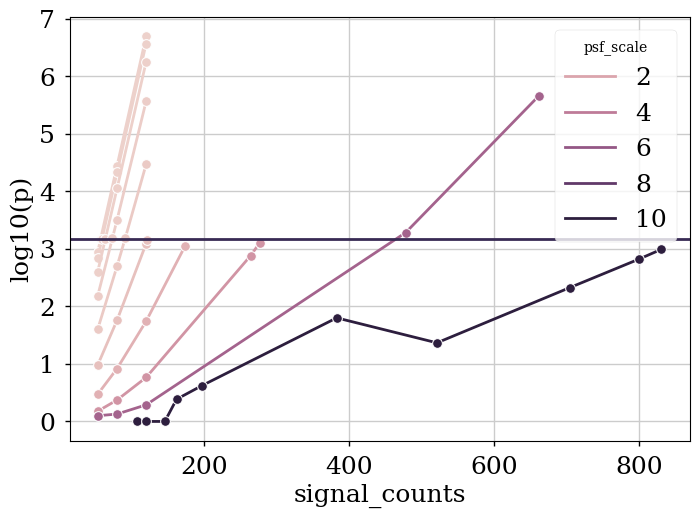

In [23]:

ax = sns.lineplot(
    data=results, 
    y="log10(p)",
    x="signal_counts",
    marker="o",
    hue="psf_scale",
)
#ax.legend([])
for t in thresholds:
    plt.axhline(-np.log10(t))
# plt.ylim(6, 7)
# plt.xlim(4.5, 6)



In [24]:
results = pd.read_pickle(join(LOCALPATH, "ngc_spectral_psf-scaling_disc_pot.pickle"))
flux = pd.DataFrame(
    results.groupby(["psf_scale"]).apply(
        lambda x: get_scaler(x, sigma5)
    )
    * E2_flux.norm,
    columns=["disc5"],
).reset_index()

n_ev = pd.DataFrame(
    results.groupby(["psf_scale"]).apply(
        lambda x: get_scaler(x, sigma5, key_y="n_sig")
    ),
    columns=["disc5"],
).reset_index()


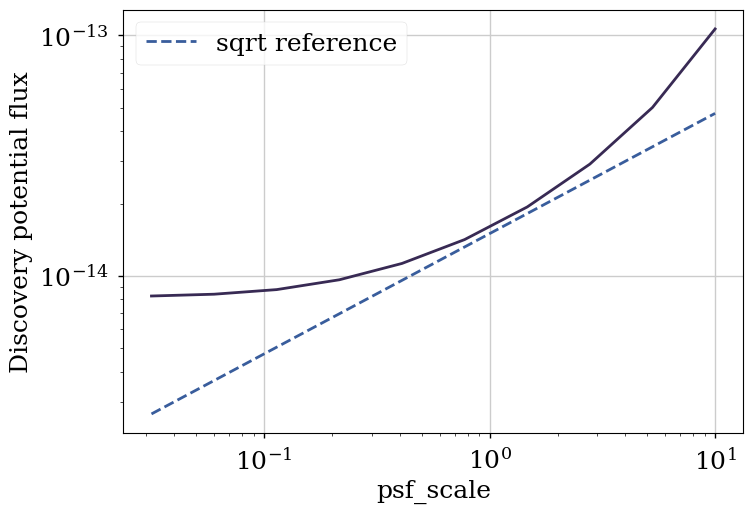

In [25]:


# mask = flux.psf_scale>0.3
# fit = np.polyfit(np.log10(flux.psf_scale[mask]), np.log10(flux.disc5[mask]), deg=1)
plt.figure()
ax = sns.lineplot(data=flux, x="psf_scale", y="disc5")
# ax.set_xscale("log")
ax.loglog()
# ax.plot(
#     flux.psf_scale, flux.psf_scale * 0.8e-14 * 0.35, label="linear reference", ls=":"
# )
ax.plot(
    flux.psf_scale,
    np.sqrt(flux.psf_scale) * 1.5E-14,
    label="sqrt reference",
    ls="--",
)
# ax.plot(flux.psf_scale, 10**np.poly1d(fit)(np.log10(flux.psf_scale)), label="fit reference", ls="--")
ax.set_ylabel("Discovery potential flux")
ax.legend()

In [20]:
raise BaseException("Ü")

BaseException: Ü

# Test analysis

## 1D, toy

   significance      pval    ident
0      2.202158  0.013827  IceCube


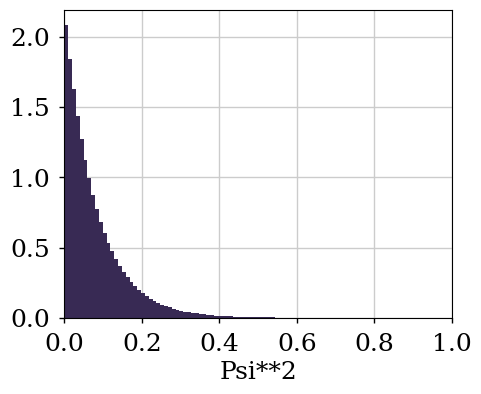

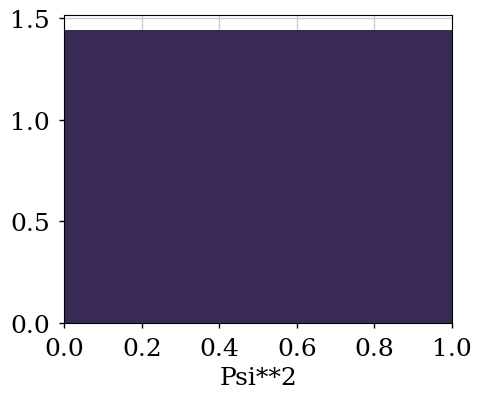

In [7]:
ident = "IceCube"
results = []

# new config
cur_bg_conf = bg_config.copy()
cur_src_conf = src_config.copy()
cur_bg_conf["dpsi_max"] = delta_psi_max
cur_bg_conf["grid_2d"] =bckg_psi2_grid
cur_src_conf["dpsi_max"] = 0
cur_src_conf["grid_2d"] = e_psi2_grid

aeff_factor_b = calc_aeff_factor(aeff_2d[ident], **cur_bg_conf)
aeff_factor_s = calc_aeff_factor(aeff_2d[ident], **cur_src_conf)

# Calculate background flux
bckg_flux = array_source_interp(
    cur_bg_conf["dec"], bckg_histo[ident], bckg_histo["IceCube"].bin_mids[0], axis=1
)

# Calculate asimov data for atmospheric background
k_b = atmo_background(
    aeff_factor=aeff_factor_b,
    bckg_vals=bckg_flux,
    energy_resolution=energy_reso["baseline"],
).sum(axis=1, return_mephisto=True)

# Calculate asimov data for astrophysical signal with power law spectrum
k_s = astro_flux(
    aeff_factor=aeff_factor_s,
    emids=10 ** aeff_factor_s.bin_mids[1],
    energy_resolution=energy_reso["baseline"],
    phi_scaling=1,
    flux_shape=E2_flux,  # powerlaw
).sum(axis=1, return_mephisto=True)


dct = dict(
    shape="powerlaw",
    aeff_factor_s=aeff_factor_s,
    aeff_factor_b=aeff_factor_b,
    k_i=k_s + k_b,
    bckg_flux=bckg_flux,
    energy_resolution=energy_reso["baseline"],
    e_0=E2_flux.E0,
    phi_0=E2_flux.norm,
)
# fix signal contribution to 0 for background fit
local_llh = lambda x: ps_llh_single_1D((x[0], 0, 3), **dct)
global_llh = lambda x: ps_llh_single_1D(x, **dct)

out_bckg = fmin_l_bfgs_b(
    local_llh,
    x0=(1,),
    approx_grad=True,
)

# this fit is not really needed, but good for crosschecking the code
out_comp = fmin_l_bfgs_b(
    global_llh,
    x0=(1, 1, E2_flux.gamma),
    approx_grad=True,
)

pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
significance = norm.isf(pval)
results.append(
    {
        "significance": significance,
        "pval": pval,
        "ident": f"IC + {ident}" if ident == "P-ONE" else ident,
        #"bg_reduction": bg_r,
        #"psf_improvement": psf_s,
        #"livetime_scaling": lt_scaling
    }
)
results = pd.DataFrame(results)
k_s.plot()
k_b.plot()
print(results)

## psf scaling

Idea: 
* Scale the PSF up and down relative to a baseline value
* Fix the spatial search window to 5 times the PSF scale
* Fix the number of bins

In [27]:
ident = "IceCube"
results = []
len_e = len(st.logE_mids)
E2_flux = PL_flux(1E-14, 2, 1E3, "powerlaw")
scalings = np.logspace(-1, 1)
for scale in scalings:
    delta_psi_max = scale * 5  # adapt the search window to PSF scale

    psi2_bins = np.linspace(
        0.0, delta_psi_max**2, num=102
    )  # fixed number of bins -> variable width depending on PSF scale
    yy = psi2_mids = get_mids(psi2_bins)

    # coordinate transform from psi -> psi**2
    xx = np.sqrt(yy)
    # transform rayleigh to psi**2
    y = rayleigh.pdf(xx, scale=scale) / xx / 2

    # make 2D so it can match the energy axis
    y = np.tile(y, len_e).reshape(len_e, len(y)).T / len_e

    e_psi2_grid = Mephistogram(  # build Mephistogram with right axes
        y,
        (psi2_bins, st.logE_bins),
        ("Psi**2", "log(E/GeV)"),
        make_hist=False,
    )
    e_psi2_grid.normalize()

    # uniform, normalized background grid
    bckg_psi2_grid = mephisto.like(e_psi2_grid, fill_value=1)
    bckg_psi2_grid.normalize()

    # new config
    cur_bg_conf = bg_config.copy()
    cur_src_conf = src_config.copy()
    cur_bg_conf["dpsi_max"] = delta_psi_max
    cur_bg_conf["grid_2d"] = bckg_psi2_grid
    cur_src_conf["dpsi_max"] = 0
    cur_src_conf["grid_2d"] = e_psi2_grid

    aeff_factor_b = calc_aeff_factor(aeff_2d[ident], **cur_bg_conf)
    aeff_factor_s = calc_aeff_factor(aeff_2d[ident], **cur_src_conf)

    # Calculate background flux
    bckg_flux = array_source_interp(
        cur_bg_conf["dec"], bckg_histo[ident], bckg_histo["IceCube"].bin_mids[0], axis=1
    )

    # Calculate asimov data for atmospheric background
    k_b = atmo_background(
        aeff_factor=aeff_factor_b,
        bckg_vals=bckg_flux,
        energy_resolution=energy_reso["baseline"],
    ).sum(axis=1, return_mephisto=True)

    # Calculate asimov data for astrophysical signal with power law spectrum
    k_s = astro_flux(
        aeff_factor=aeff_factor_s,
        emids=10 ** aeff_factor_s.bin_mids[1],
        energy_resolution=energy_reso["baseline"],
        phi_scaling=1,
        flux_shape=E2_flux,  # powerlaw
    ).sum(axis=1, return_mephisto=True)
    if False:
        plot_multiple_mephistograms([k_b, k_s])
    dct = dict(
        shape="powerlaw",
        aeff_factor_s=aeff_factor_s,
        aeff_factor_b=aeff_factor_b,
        k_i=k_s + k_b,
        bckg_flux=bckg_flux,
        energy_resolution=energy_reso["baseline"],
        e_0=E2_flux.E0,
        phi_0=E2_flux.norm,
    )
    # fix signal contribution to 0 for background fit
    local_llh = lambda x: ps_llh_single_1D((x[0], 0, 3), **dct)
    global_llh = lambda x: ps_llh_single_1D(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )

    # this fit is not really needed, but good for crosschecking the code
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, E2_flux.gamma),
        approx_grad=True,
    )

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = norm.isf(pval)
    results.append(
        {
            "significance": significance,
            "pval": pval,
            "ident": f"IC + {ident}" if ident == "P-ONE" else ident,
            "psf_scale": scale,
        }
    )


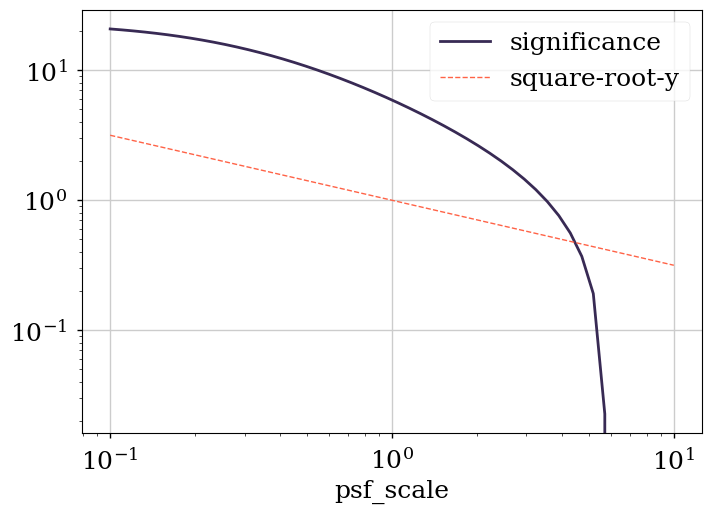

In [30]:
results = pd.DataFrame(results)
ax = results.plot(x="psf_scale", y="significance")
ax.plot(scalings, 1/np.sqrt(scalings), ls="--", color="tomato", lw=1, label= "square-root-y")
ax.loglog()
ax.legend()


## discovery potential


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:01<00:00, 13.79it/s]


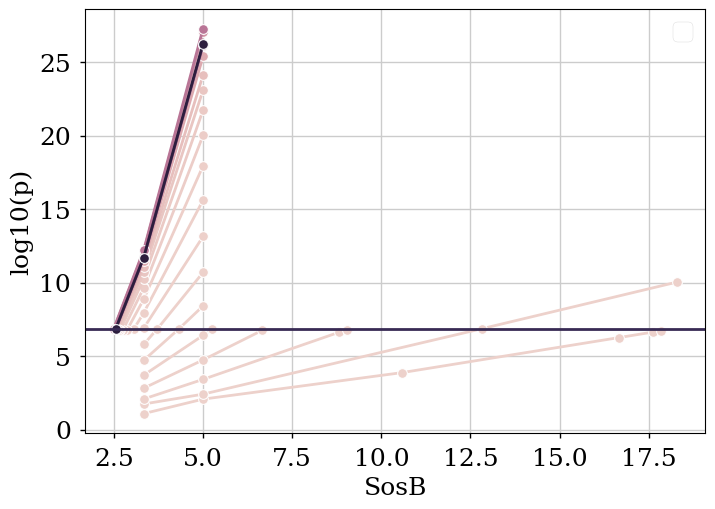

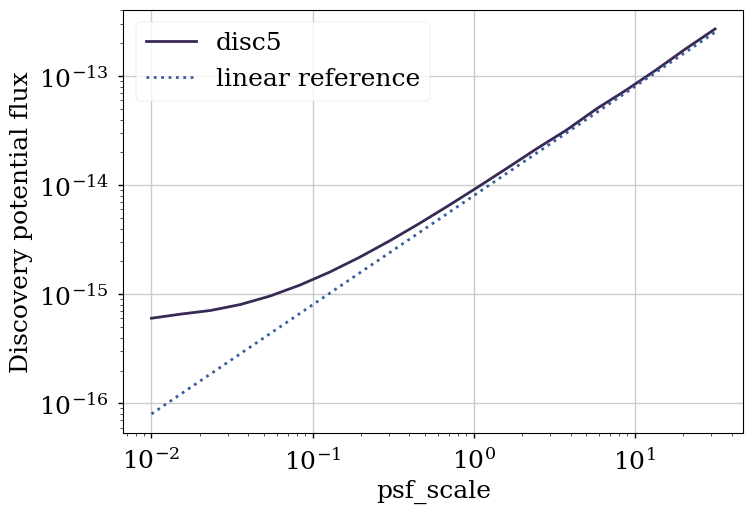

<Figure size 800x550 with 0 Axes>

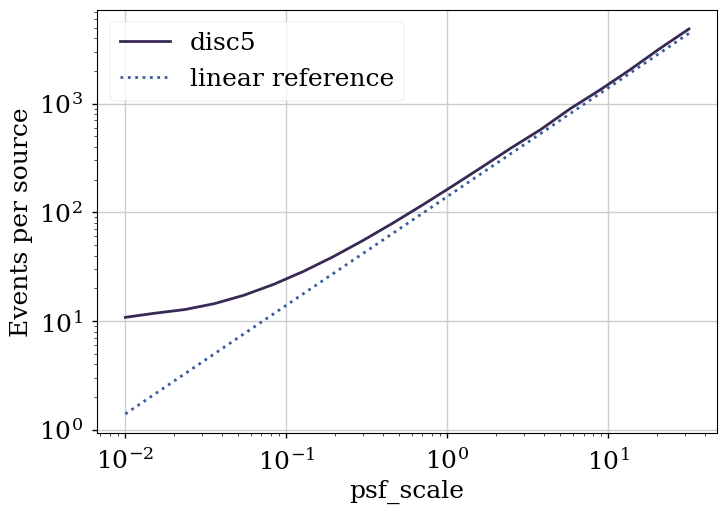

In [17]:
ident = "IceCube"
results = []
len_e = len(st.logE_mids)
E2_flux = PL_flux(1e-14, 2, 1e3, "powerlaw")
scalings = np.logspace(-2, 1.5, 20)
thresholds = [sigma5]

for scale in tqdm(scalings):
    delta_psi_max = scale * 5  # adapt

    psi2_bins = np.arange(
        0.0, delta_psi_max**2, step=scale**2
    )  # step size fixed in relation to PSF scale
    yy = psi2_mids = get_mids(psi2_bins)

    # coordinate transform from psi -> psi**2
    xx = np.sqrt(yy)
    # transform rayleigh to psi**2
    y = rayleigh.pdf(xx, scale=scale) / xx / 2

    # make 2D so it can match the energy axis
    y = np.tile(y, len_e).reshape(len_e, len(y)).T / len_e

    e_psi2_grid = Mephistogram(  # build Mephistogram with right axes
        y,
        (psi2_bins, st.logE_bins),
        ("Psi**2", "log(E/GeV)"),
        make_hist=False,
    )
    e_psi2_grid.normalize()

    # uniform, normalized background grid
    bckg_psi2_grid = mephisto.like(e_psi2_grid, fill_value=1)
    bckg_psi2_grid.normalize()

    # new config
    cur_bg_conf = bg_config.copy()
    cur_src_conf = src_config.copy()
    cur_bg_conf["dpsi_max"] = delta_psi_max
    cur_bg_conf["grid_2d"] = bckg_psi2_grid
    cur_src_conf["dpsi_max"] = 0
    cur_src_conf["grid_2d"] = e_psi2_grid

    aeff_factor_b = calc_aeff_factor(aeff_2d[ident], **cur_bg_conf)
    aeff_factor_s = calc_aeff_factor(aeff_2d[ident], **cur_src_conf)

    # Calculate background flux
    bckg_flux = array_source_interp(
        cur_bg_conf["dec"], bckg_histo[ident], bckg_histo["IceCube"].bin_mids[0], axis=1
    )

    # Calculate asimov data for atmospheric background
    k_b = atmo_background(
        aeff_factor=aeff_factor_b,
        bckg_vals=bckg_flux,
        energy_resolution=energy_reso["baseline"],
    ).sum(axis=1, return_mephisto=True)

    # Calculate asimov data for astrophysical signal with power law spectrum
    k_s = astro_flux(
        aeff_factor=aeff_factor_s,
        emids=10 ** aeff_factor_s.bin_mids[1],
        energy_resolution=energy_reso["baseline"],
        phi_scaling=1,
        flux_shape=E2_flux,  # powerlaw
    ).sum(axis=1, return_mephisto=True)

    # k_s.plot()

    # calculate an estimate for the flux scaling
    scaler = 5 / (np.sum(k_s) / np.sqrt(np.sum(k_b)))
    current_thresholds = copy(thresholds)
    count = 0

    # calculate the significance with various flux scalings to obtain
    # the 5-sigma discovery threshold by interpolation
    while len(current_thresholds) > 0:
        current_k_s = k_s * scaler
        current_k = current_k_s + k_b

        dct = dict(
            shape="powerlaw",
            aeff_factor_s=aeff_factor_s,
            aeff_factor_b=aeff_factor_b,
            k_i=current_k,
            bckg_flux=bckg_flux,
            energy_resolution=energy_reso["baseline"],
            e_0=E2_flux.E0,
            phi_0=E2_flux.norm,
        )
        # fix signal contribution to 0 for background fit
        local_llh = lambda x: ps_llh_single_1D((x[0], 0, 3), **dct)
        global_llh = lambda x: ps_llh_single_1D(x, **dct)

        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1,),
            approx_grad=True,
        )

        # this fit is not really needed, but good for crosschecking the code
        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1, 1, E2_flux.gamma),
            approx_grad=True,
        )
        logP = -np.log10(chi2.sf(out_bckg[1] - out_comp[1], 2))

        pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
        significance = norm.isf(pval)
        tmp_dct = {
            "ident": ident,
            "psf_scale": scale,
            "scaler": scaler,
            "cur_thresh": current_thresholds[0],
            "SosB": np.sum(current_k_s) / np.sqrt(np.sum(k_b)),
            "n_b": np.sum(k_b),
            "n_sig": np.sum(current_k_s),
            "log10(p)": logP,
        }
        results.append(tmp_dct)
        tmp_df = pd.DataFrame(results)
        mask = (tmp_df.psf_scale == scale) & (
            tmp_df.cur_thresh == current_thresholds[0]
        )
        scaler = scaling_estimation(
            tmp_df.loc[mask], current_thresholds, scaler, stop_here=0.2
        )

        if scaler == -1:
            break

results = pd.DataFrame(results)
ax = sns.lineplot(
    data=results, #.loc[df.psf_scale == "base"],
    y="log10(p)",
    x="SosB",
    marker="o",
    hue="psf_scale",
)
ax.legend([])
for t in thresholds:
    plt.axhline(-np.log10(t))
# plt.ylim(6, 7)
# plt.xlim(4.5, 6)
flux = pd.DataFrame(
    results.groupby(["psf_scale"]).apply(
        lambda x: get_scaler(x, sigma5)
    )
    * E2_flux.norm,
    columns=["disc5"],
).reset_index()

n_ev = pd.DataFrame(
    results.groupby(["psf_scale"]).apply(
        lambda x: get_scaler(x, sigma5, key_y="n_sig")
    ),
    columns=["disc5"],
).reset_index()

ax = flux.plot(x="psf_scale", y="disc5")
ax.loglog()
ax.plot(scalings, scalings * 0.8E-14, label="linear reference", ls=":")
ax.set_ylabel("Discovery potential flux")
ax.legend()


plt.figure()
ax = n_ev.plot(x="psf_scale", y="disc5")
ax.loglog()
ax.plot(scalings, scalings * 1.4E2, label="linear reference", ls=":")
ax.set_ylabel("Events per source")
ax.legend()

# simplified 1-bin analysis 

... finally understand the S/sqrt(B) scaling!

In [ ]:
import numpy as np
from tools import poisson_llh
from scipy.optimize import fmin_l_bfgs_b
from scipy.stats import poisson, chi2, norm
import pandas as pd
import seaborn as sns
plt = sns.mpl.pyplot

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


# background scaling

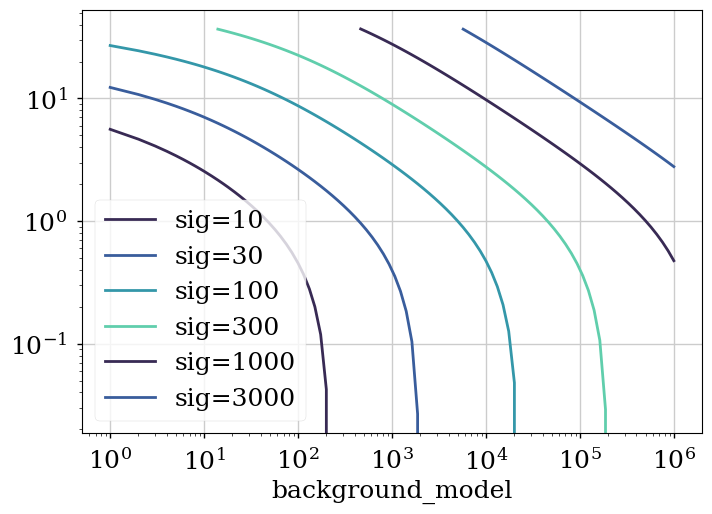

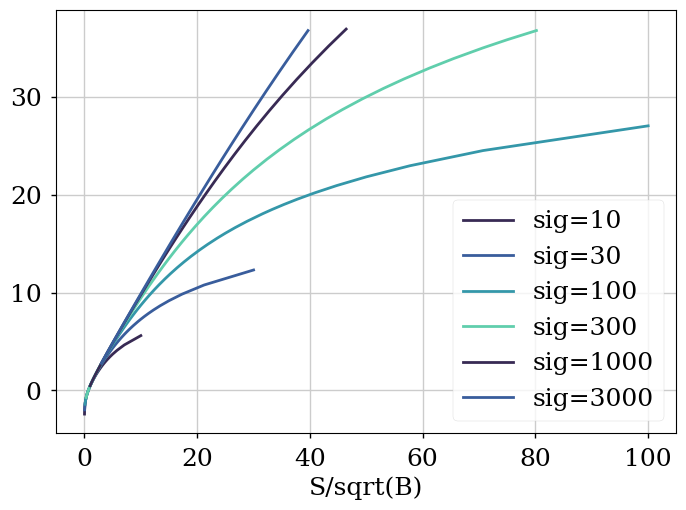

In [ ]:
f, ax = plt.subplots()
f, ax2 = plt.subplots()

for sig in [10, 30, 100, 300, 1000, 3000]:
    # model
    mu_b = np.array(np.logspace(0, 6, num=100), dtype=int)
    mu_s = np.full_like(mu_b, sig)

    # data
    k_sum = mu_b + mu_s

    bg_llh = -2 * poisson.logpmf(k_sum, mu_b)
    signal_llh = -2 * poisson.logpmf(k_sum, mu_b + mu_s)

    results = pd.DataFrame(
        dict(
            pval=chi2.sf(bg_llh - signal_llh, 1).tolist(),
            significance=norm.isf(chi2.sf(bg_llh - signal_llh, 1)).tolist(),
            signal=sig,
            background=mu_b.tolist(),
            background_model=mu_b.tolist(),
        )
    )
    agg_results = results.groupby("background_model").median()
    agg_results["S/sqrt(B)"] = agg_results.signal / np.sqrt(agg_results.index.values)
    ax = agg_results.plot(y="significance", ax=ax, label=f"sig={sig}")
    ax2 = agg_results.plot(x="S/sqrt(B)", y="significance", ax=ax2, label=f"sig={sig}")
ax.loglog()
ax.legend()

# ax2.loglog()
ax2.legend()

# ax2.set_xlim(0.3, None)

# signal scaling

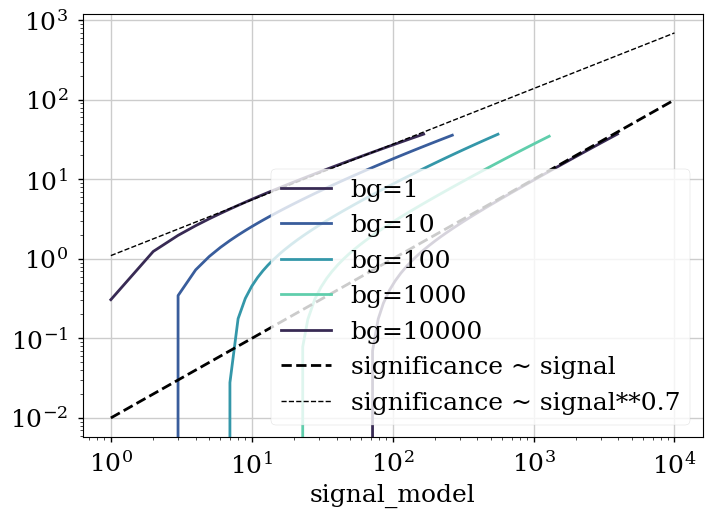

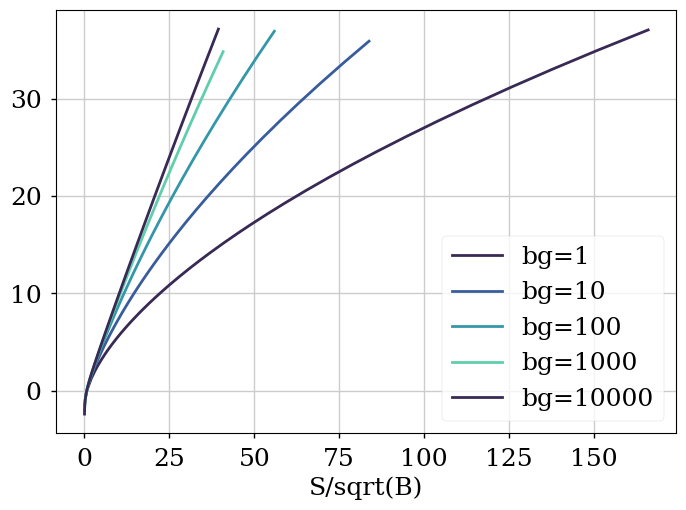

In [ ]:
f, ax = plt.subplots()
f, ax2 = plt.subplots()
mu_s = np.array(np.logspace(0, 4, num=100), dtype=int)

for bg in [1, 10, 100, 1000, 10000]:
    # model
    mu_b = np.full_like(mu_s, bg)

    # data 
    k_sum = mu_b + mu_s


    bg_llh = -2 * poisson.logpmf(k_sum, mu_b)
    signal_llh = -2 * poisson.logpmf(k_sum, mu_b + mu_s)

    results = pd.DataFrame(
        dict(
            pval=chi2.sf(bg_llh - signal_llh, 1).tolist(),
            significance=norm.isf(chi2.sf(bg_llh - signal_llh, 1)).tolist(),
            signal=mu_s.tolist(),
            background=bg,
            signal_model=mu_s.tolist(),
        )
    )
    agg_results = results.groupby("signal_model").median()
    agg_results["S/sqrt(B)"] = agg_results.index.values / np.sqrt(agg_results.background)
    ax = agg_results.plot(y="significance", ax=ax, label=f"bg={bg}")
    ax2 = agg_results.plot(x="S/sqrt(B)", y="significance", ax=ax2, label=f"bg={bg}")
ax.loglog()
ax.plot(mu_s, mu_s/100,  color="k", ls="--", label="significance ~ signal")
ax.plot(mu_s, mu_s**0.7 *1.1,  color="k", ls="--", lw=1, label="significance ~ signal**0.7")

ax.legend()

#ax2.loglog()
ax2.legend()

#ax2.set_xlim(0.3, None)

